In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [35]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [36]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442300169800_engineered.csv')
# buat df baru hanya READ_DATE dan KWH_EXP saja
df = df[['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss']]
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss
READ_DATE,,,,,,,,,,,
2019-02-26,5.370424,29.1,24.5,35.0,130.0,7.5,1009.4,28.6,79.0,0.0,10.9
2019-02-27,5.944421,28.5,24.5,34.0,126.0,7.3,1007.9,28.7,78.0,0.0,11.6
2019-02-28,5.425158,28.2,24.8,33.2,120.0,7.2,1008.2,28.0,83.0,0.0,11.6
2019-03-01,5.506770,28.3,24.8,32.8,81.0,7.1,1008.5,28.0,80.0,0.0,6.1
2019-03-02,5.817964,28.4,24.4,32.6,100.0,6.7,1008.5,27.8,82.0,0.0,8.9
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,8.532623,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4
2024-05-28,8.532623,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2
2024-05-29,8.337785,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7


In [37]:
lambda_daily_365 = 1600 * (365 / 4) ** 4  # Hasil: sekitar 69.3 x 10^9
print(lambda_daily_365)
# decompose menggunakan hpfilter
cycle, trend = hpfilter(df['tavg'], lamb=lambda_daily_365)
df['trend_tavg'] = trend
df['cycle_tavg'] = cycle
cycle, trend = hpfilter(df['tmin'], lamb=lambda_daily_365)
df['trend_tmin'] = trend
df['cycle_tmin'] = cycle
cycle, trend = hpfilter(df['tmax'], lamb=lambda_daily_365)
df['trend_tmax'] = trend
df['cycle_tmax'] = cycle
cycle, trend = hpfilter(df['wdir'], lamb=lambda_daily_365)
df['trend_wdir'] = trend
df['cycle_wdir'] = cycle
cycle, trend = hpfilter(df['wspd'], lamb=lambda_daily_365)
df['trend_wspd'] = trend
df['cycle_wspd'] = cycle
cycle, trend = hpfilter(df['pres'], lamb=lambda_daily_365)
df['trend_pres'] = trend
df['cycle_pres'] = cycle
cycle, trend = hpfilter(df['Tavg'], lamb=lambda_daily_365)
df['trend_Tavg'] = trend
df['cycle_Tavg'] = cycle
cycle, trend = hpfilter(df['RH_avg'], lamb=lambda_daily_365)
df['trend_RH_avg'] = trend
df['cycle_RH_avg'] = cycle
cycle, trend = hpfilter(df['RR'], lamb=lambda_daily_365)
df['trend_RR'] = trend
df['cycle_RR'] = cycle
cycle, trend = hpfilter(df['ss'], lamb=lambda_daily_365)
df['trend_ss'] = trend
df['cycle_ss'] = cycle

110930628906.25


In [38]:
df.drop(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss'], axis=1, inplace=True)

In [39]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE KWH_EXP	tavg	tmin	tmax	wdir	wspd	pres	Tavg	RH_avg	RR	ss
019-01-01	1.704497	25.7	24.8	30.2	44.0	6.4	1008.9	25.7	96.0	12.9	7.5
2019-01-02	1.804380	26.0	24.1	29.2	21.0	5.4	1009.2	25.9	90.0	42.7	6.7
2019-01-03	1.606232	24.6	24.0	27.3	340.0	4.1	1010.3	24.9	94.0	0.5	0.1
2019-01-04	1.220510	26.2	23.0	29.8	340.0	6.9	1011.4	25.8	88.0	34.6	0.1
2019-01-05	0.980424	26.9	23.6	30.2	284.0	6.3	1011.7	26.7	88.0	2.1	3.2
"""


train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [40]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [41]:
train_scaled_features

array([[ 0.23245265, -1.71331963,  1.58561089, ..., -0.34589591,
         2.03661635,  0.84674235],
       [ 0.40709426, -1.71067615,  1.01380428, ..., -0.34596635,
         2.03325161,  1.09348255],
       [ 0.2491057 , -1.70803267,  0.72782447, ..., -0.34603678,
         2.02988686,  1.09372731],
       ...,
       [-1.09727749,  2.03642179, -1.68026297, ...,  0.67824574,
        -1.14854085,  0.02203082],
       [-0.97493805,  2.04095714, -1.6805255 , ..., -0.04742186,
        -1.14860017, -2.05556926],
       [-1.04252062,  2.04549779, -0.34692996, ...,  3.30639921,
        -1.14865688, -2.75983781]])

In [42]:
# # Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [43]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 23: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


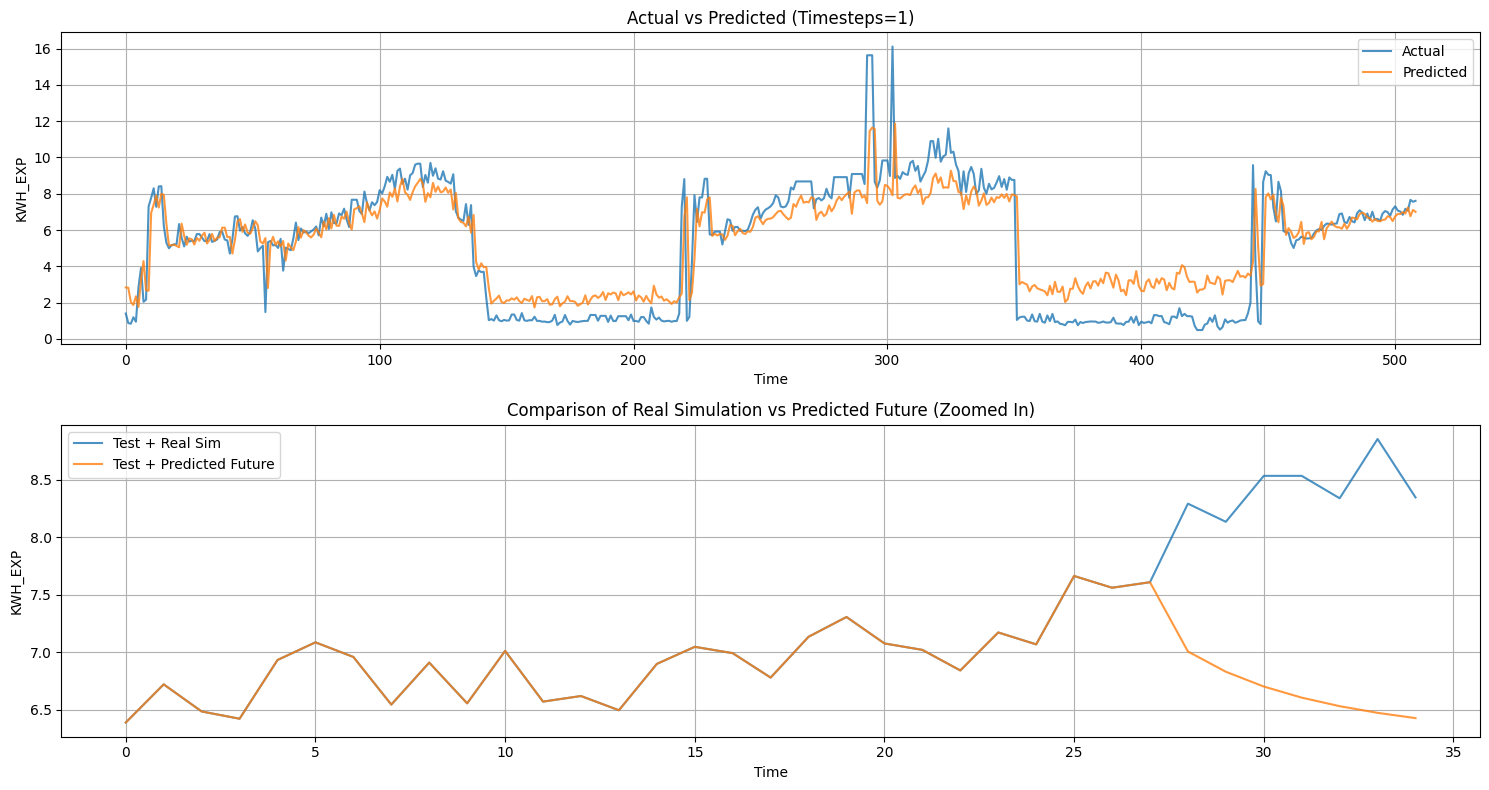


Metrics for timesteps=1:
MSE: 2.4433
R²: 0.7852
MAPE: 0.6928
MAE: 1.1721
Training time for timesteps = 1: 9.86 seconds

Training model with selected features and timesteps = 2
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


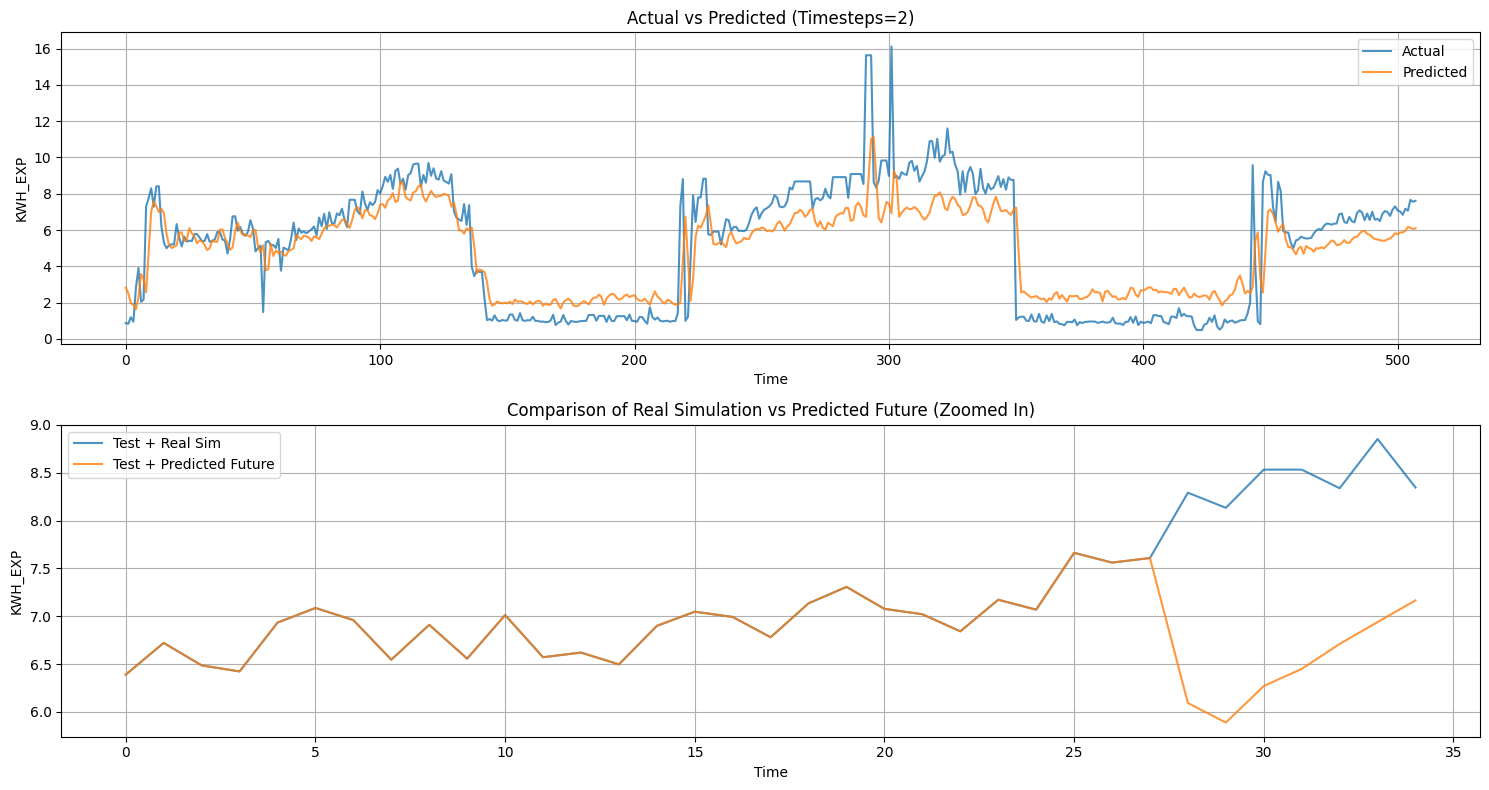


Metrics for timesteps=2:
MSE: 2.8939
R²: 0.7455
MAPE: 0.6084
MAE: 1.3306
Training time for timesteps = 2: 7.82 seconds

Training model with selected features and timesteps = 3
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


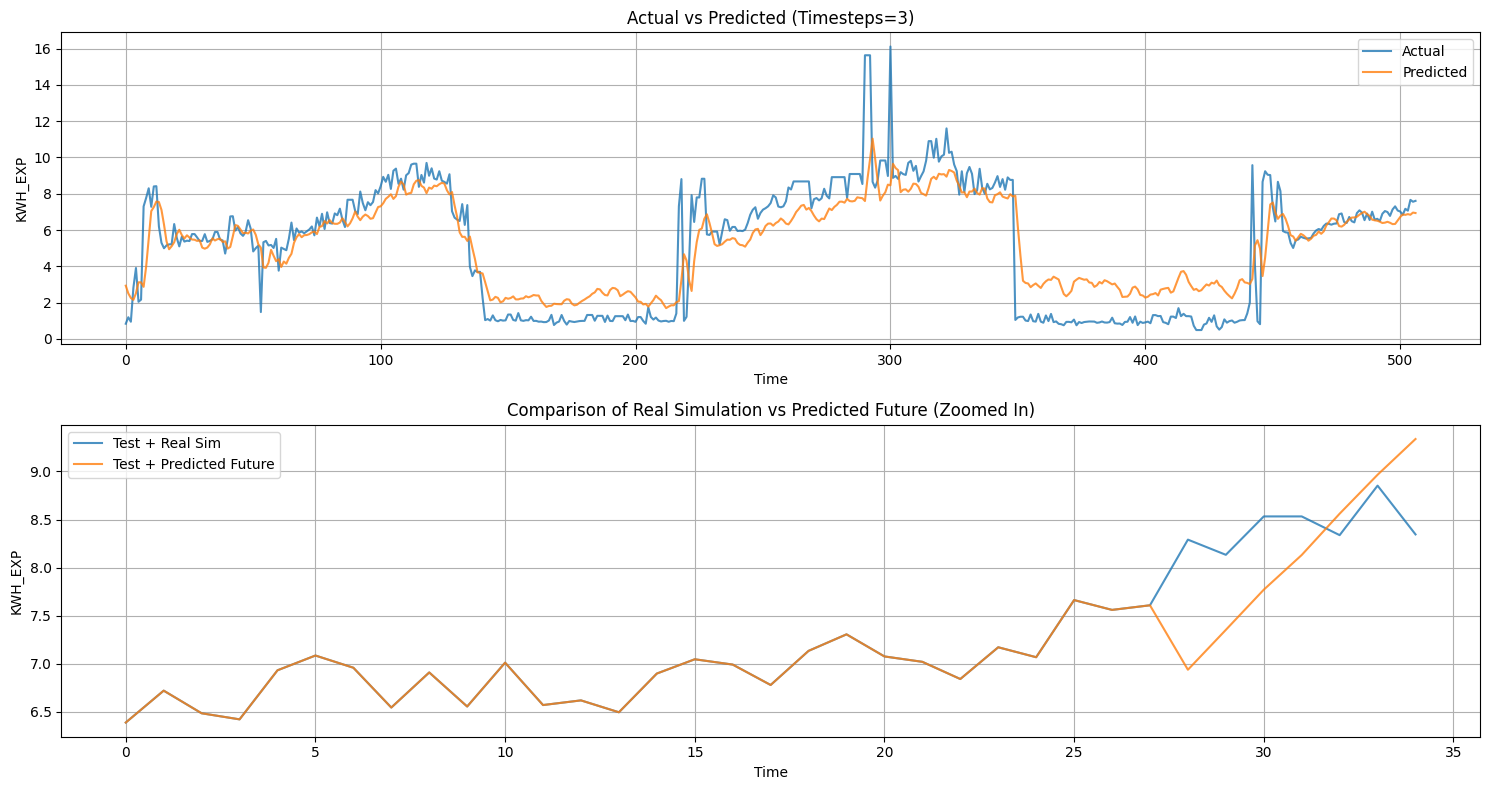


Metrics for timesteps=3:
MSE: 2.6546
R²: 0.7663
MAPE: 0.6848
MAE: 1.2253
Training time for timesteps = 3: 9.09 seconds

Training model with selected features and timesteps = 4
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


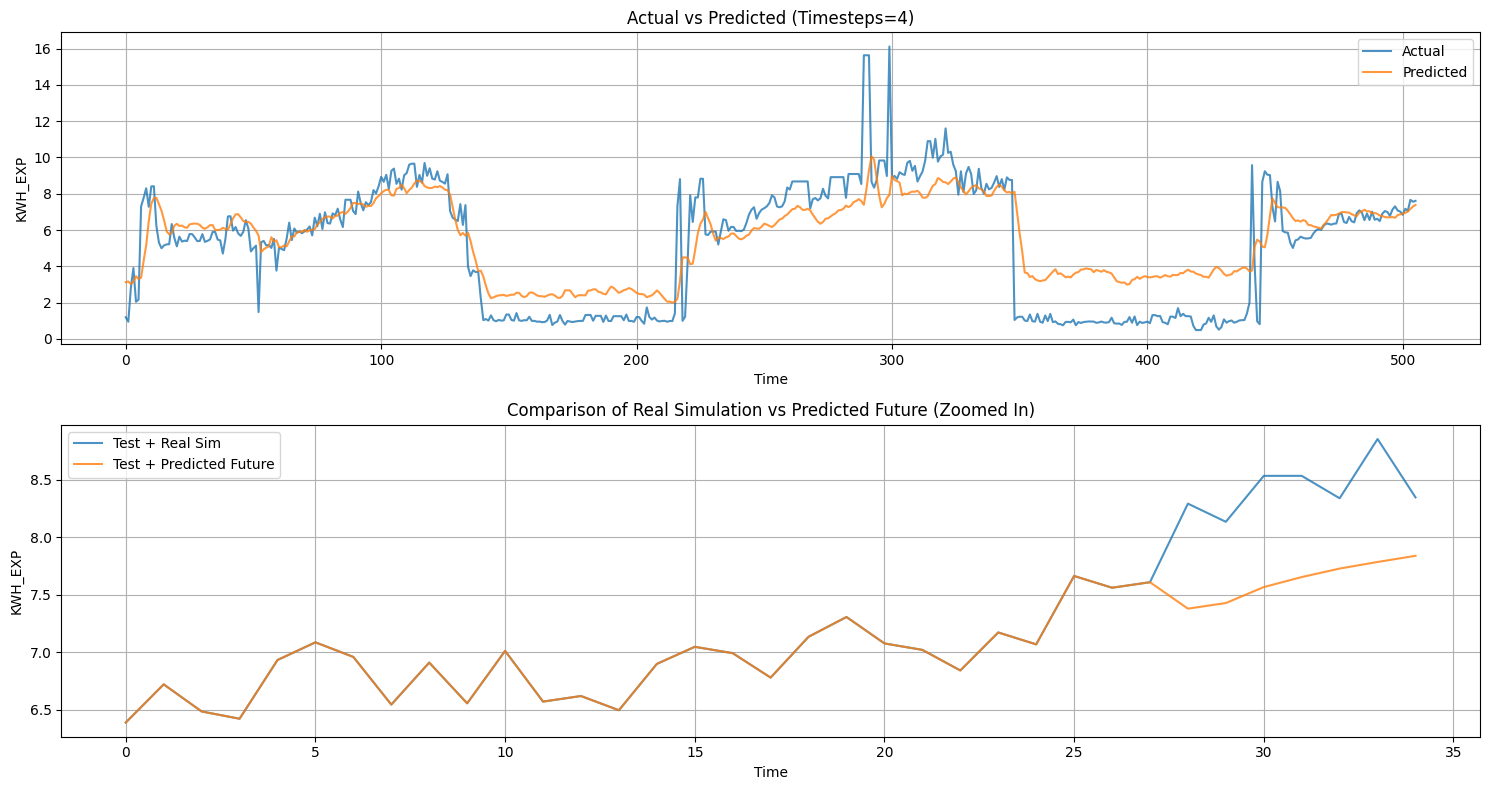


Metrics for timesteps=4:
MSE: 3.3586
R²: 0.7039
MAPE: 0.8602
MAE: 1.4005
Training time for timesteps = 4: 8.37 seconds

Training model with selected features and timesteps = 5
Epoch 10: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


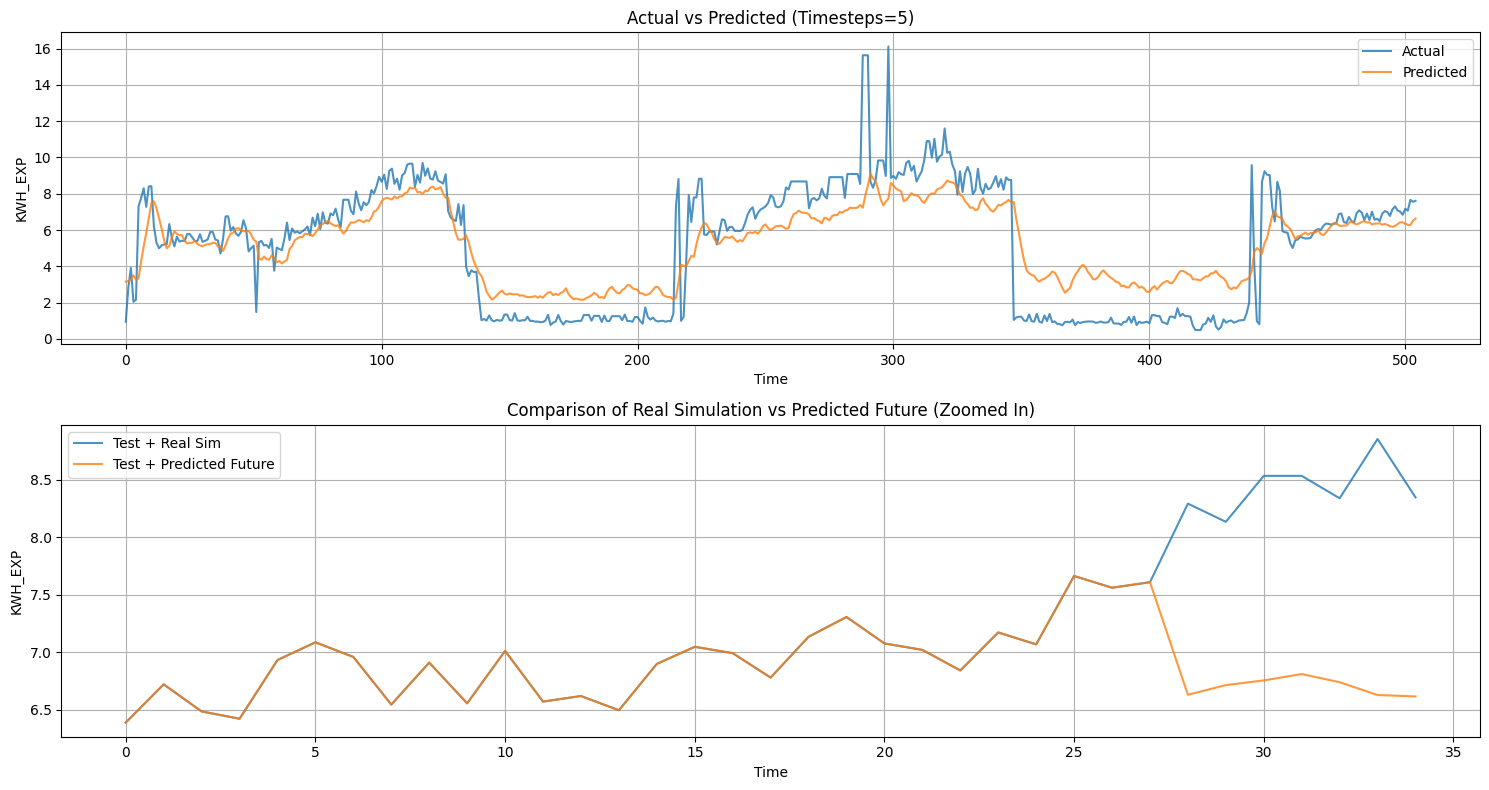


Metrics for timesteps=5:
MSE: 3.3636
R²: 0.7033
MAPE: 0.8125
MAE: 1.4430
Training time for timesteps = 5: 7.36 seconds

Training model with selected features and timesteps = 6
Epoch 10: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


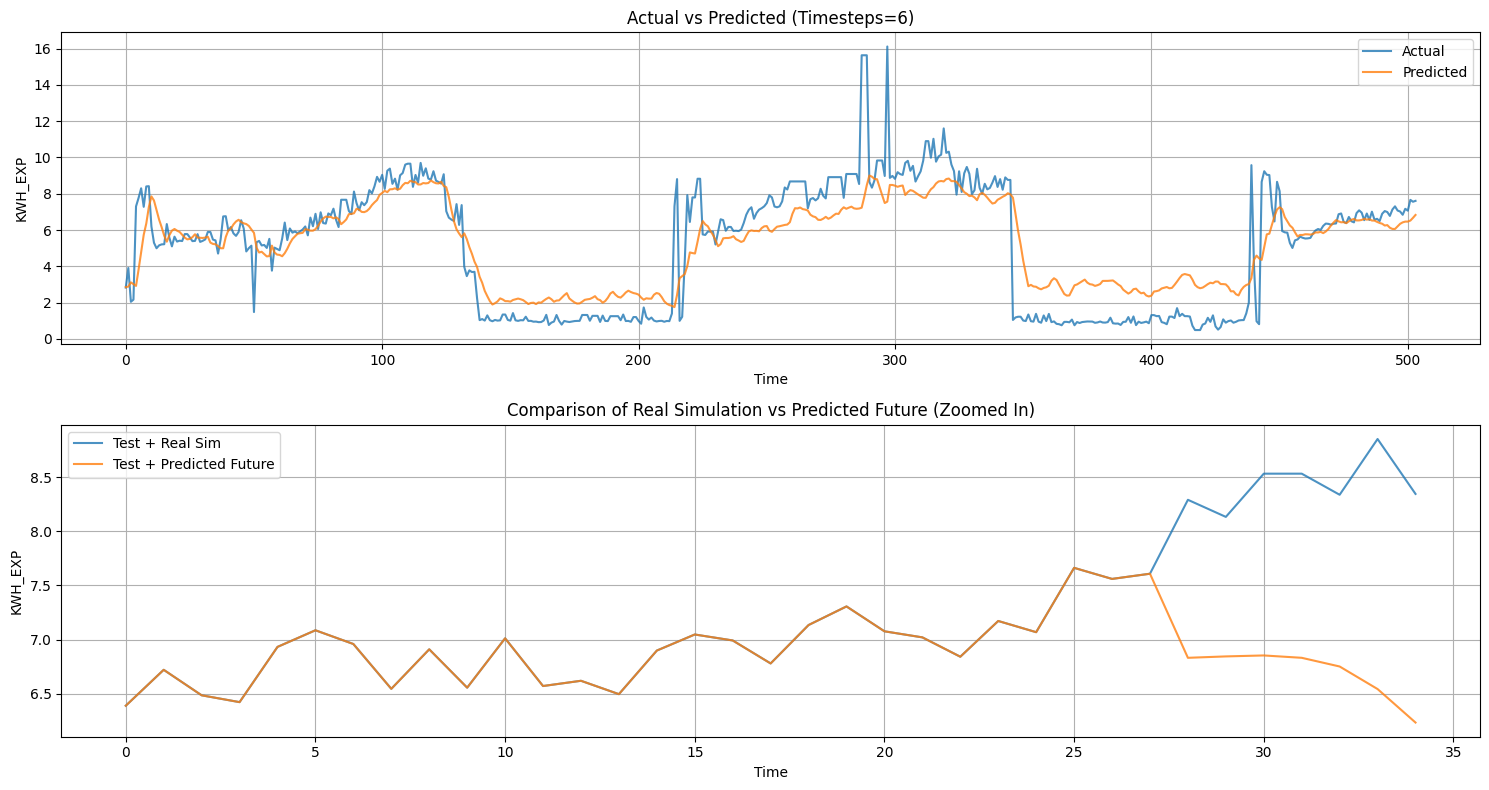


Metrics for timesteps=6:
MSE: 2.9362
R²: 0.7407
MAPE: 0.6972
MAE: 1.2778
Training time for timesteps = 6: 8.73 seconds

Training model with selected features and timesteps = 7
Epoch 10: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


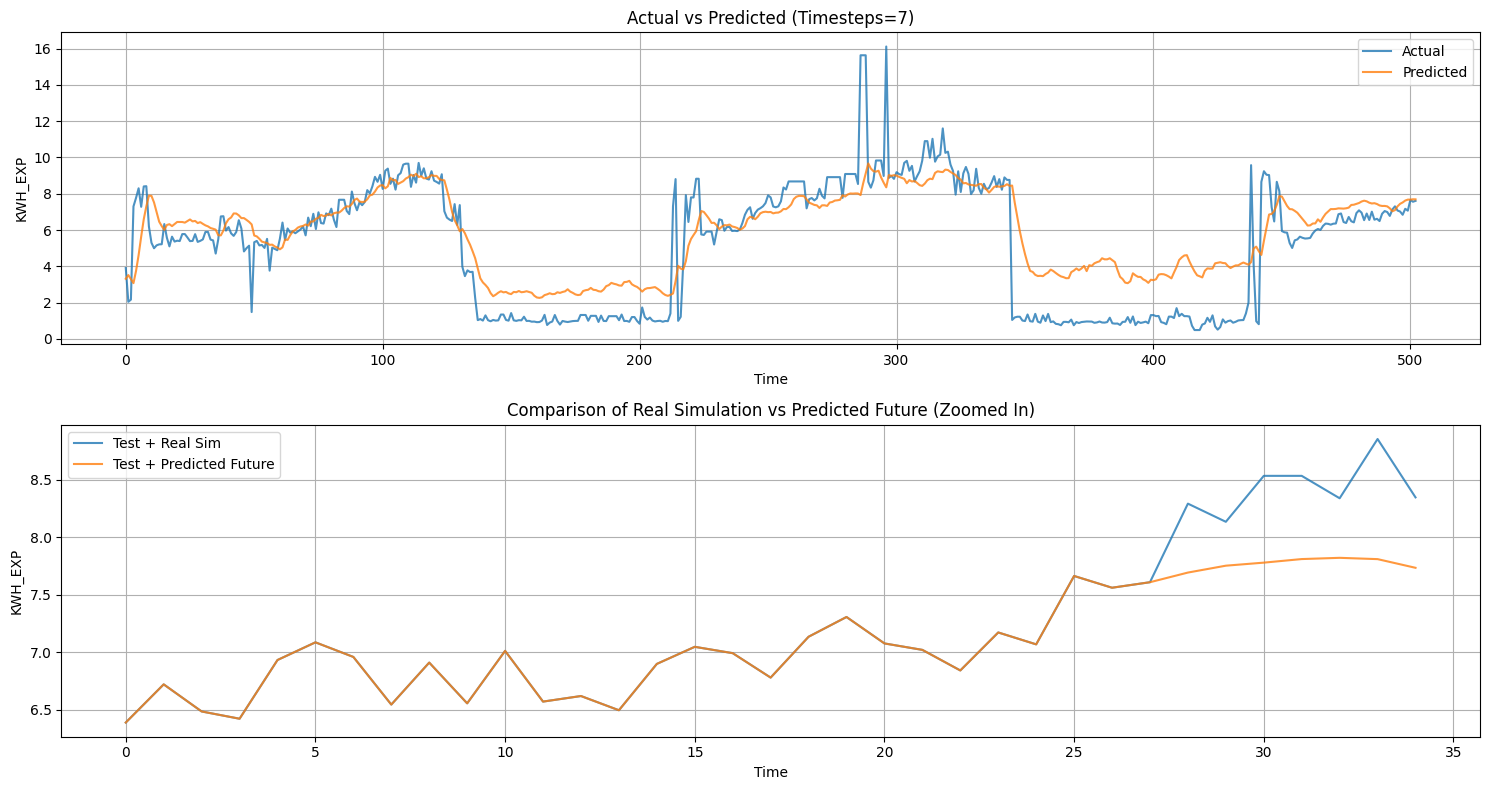


Metrics for timesteps=7:
MSE: 3.6062
R²: 0.6818
MAPE: 0.9334
MAE: 1.4264
Training time for timesteps = 7: 8.11 seconds
Total training execution time: 59.33 seconds


In [44]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [45]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [46]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 3, 4, 5, 6, 7]


Training model with selected features and timesteps = 1
Epoch 33: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


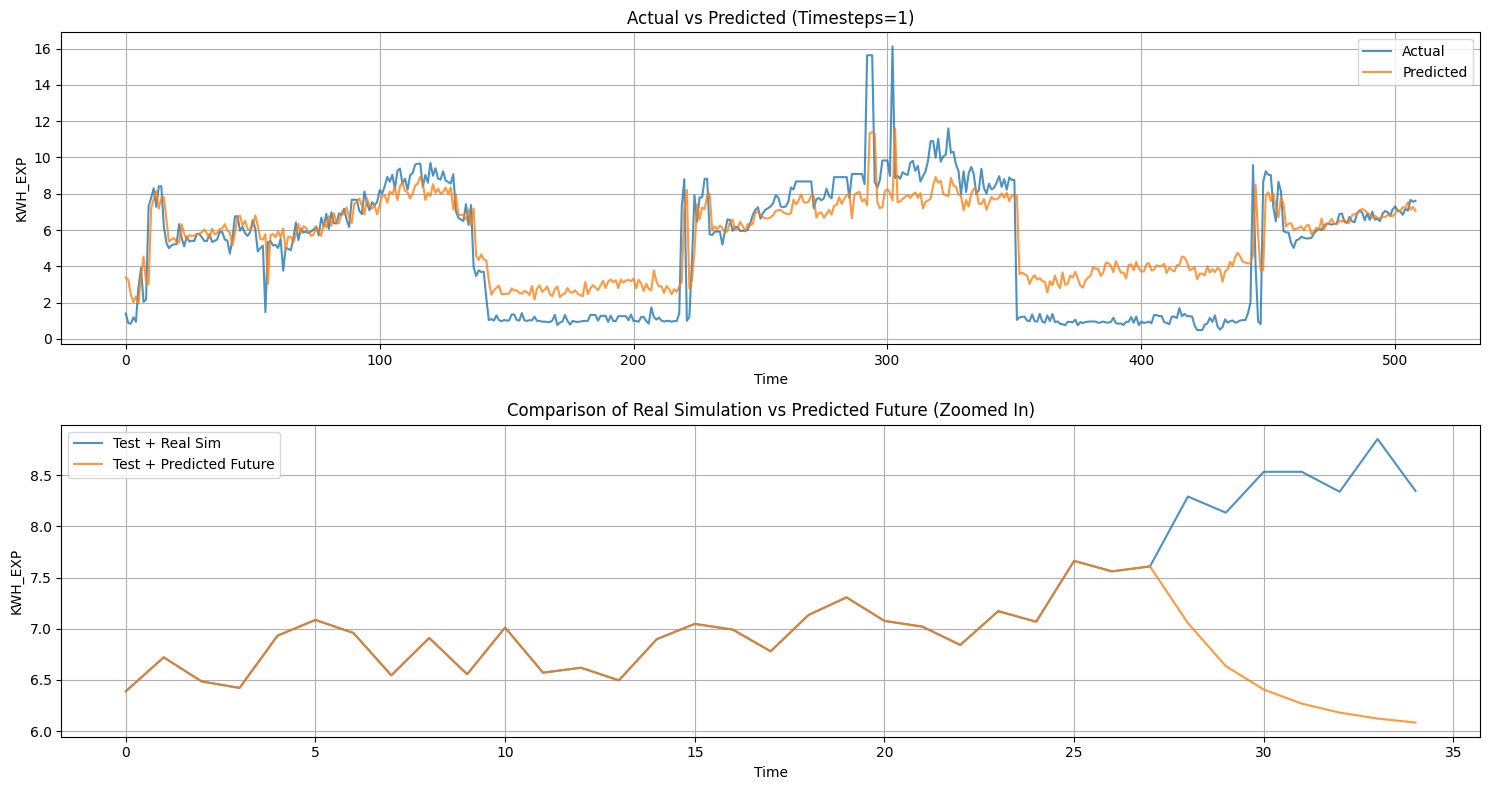


Metrics for timesteps=1:
MSE: 3.3577
R²: 0.7049
MAPE: 0.9170
MAE: 1.4047
Training time for timesteps = 1: 8.98 seconds

Training model with selected features and timesteps = 3
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


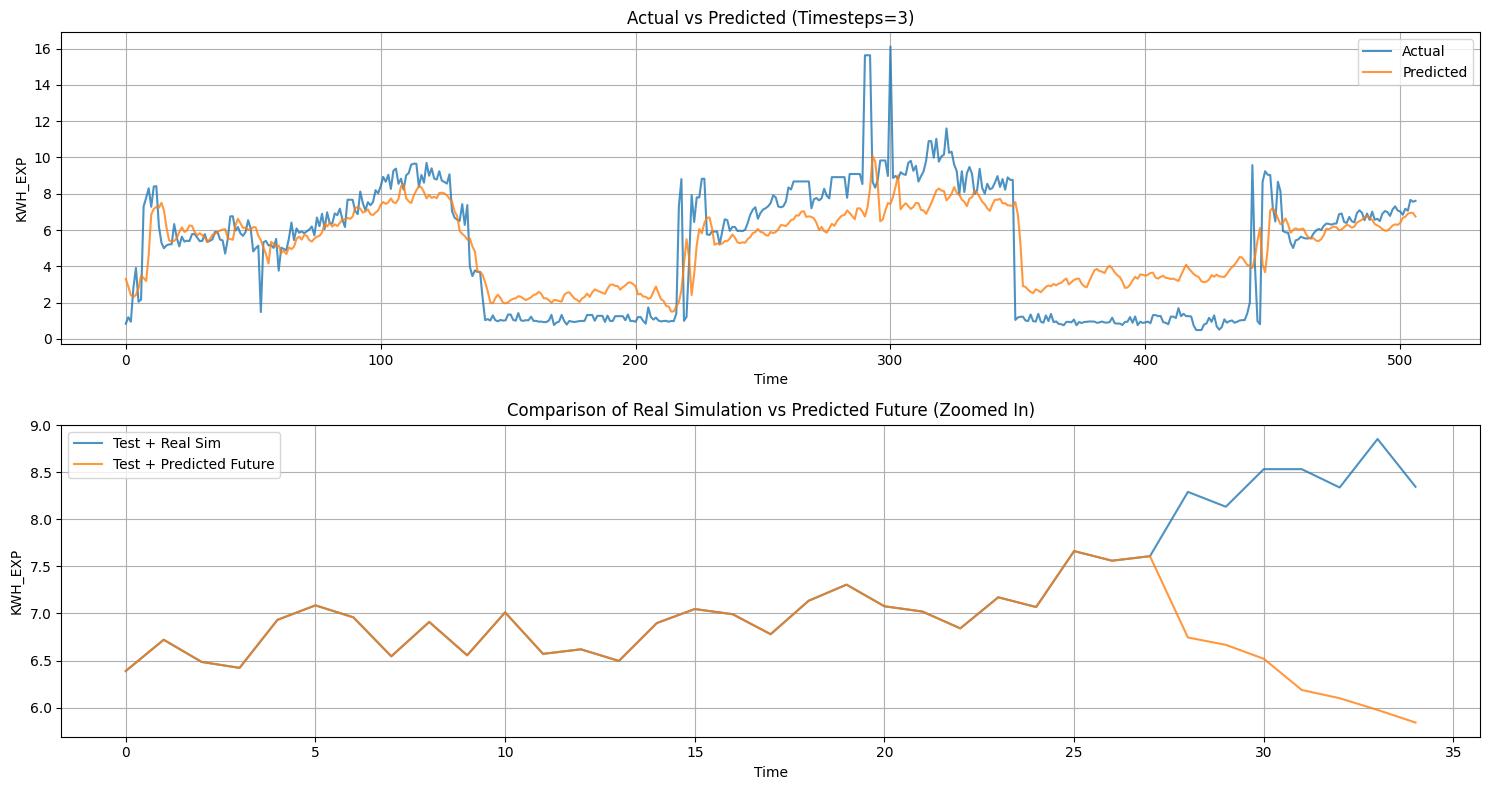


Metrics for timesteps=3:
MSE: 3.7636
R²: 0.6687
MAPE: 0.8276
MAE: 1.4993
Training time for timesteps = 3: 7.39 seconds

Training model with selected features and timesteps = 3
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


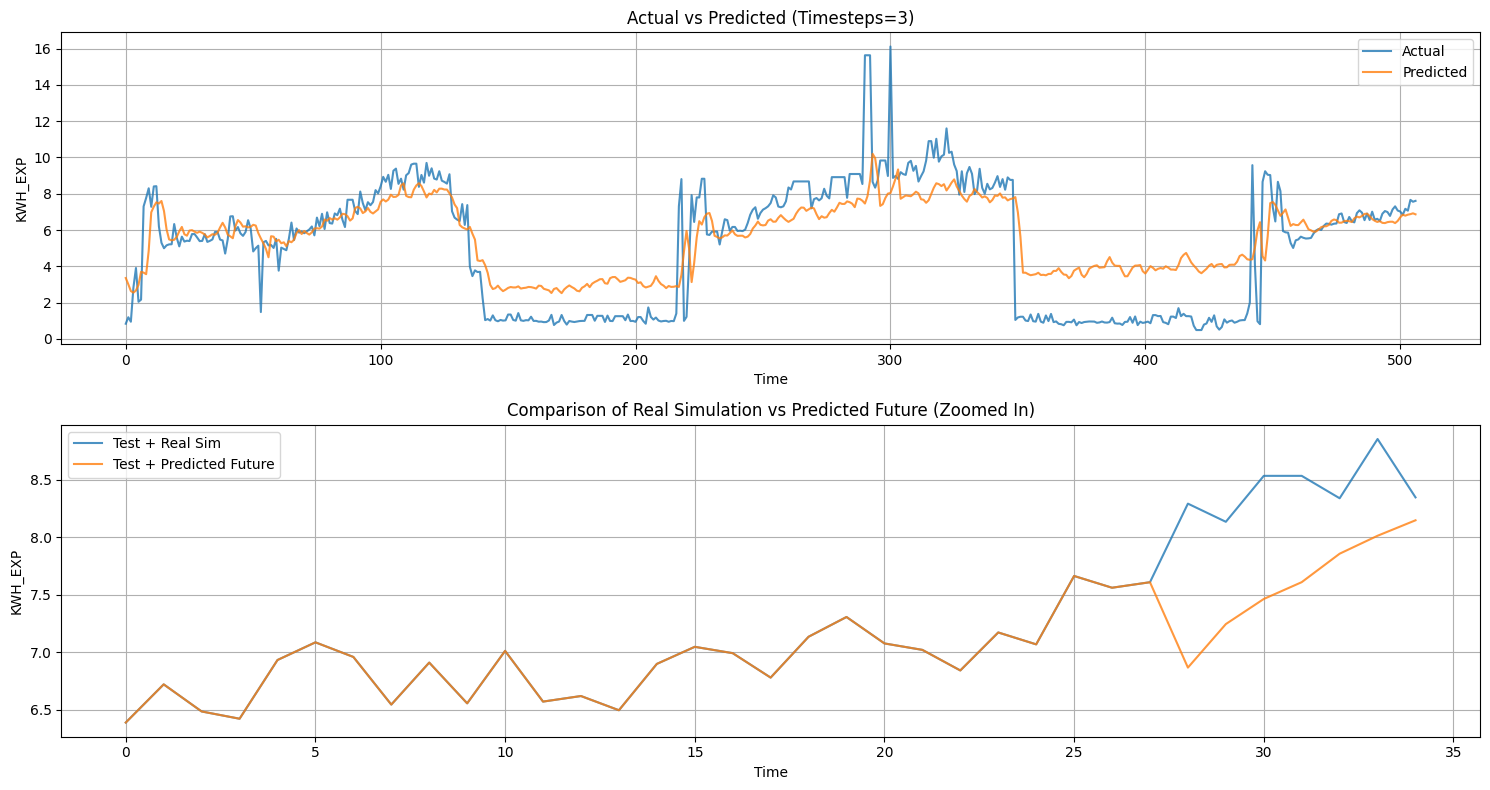


Metrics for timesteps=3:
MSE: 4.0591
R²: 0.6426
MAPE: 1.0012
MAE: 1.5609
Training time for timesteps = 3: 7.73 seconds

Training model with selected features and timesteps = 4
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


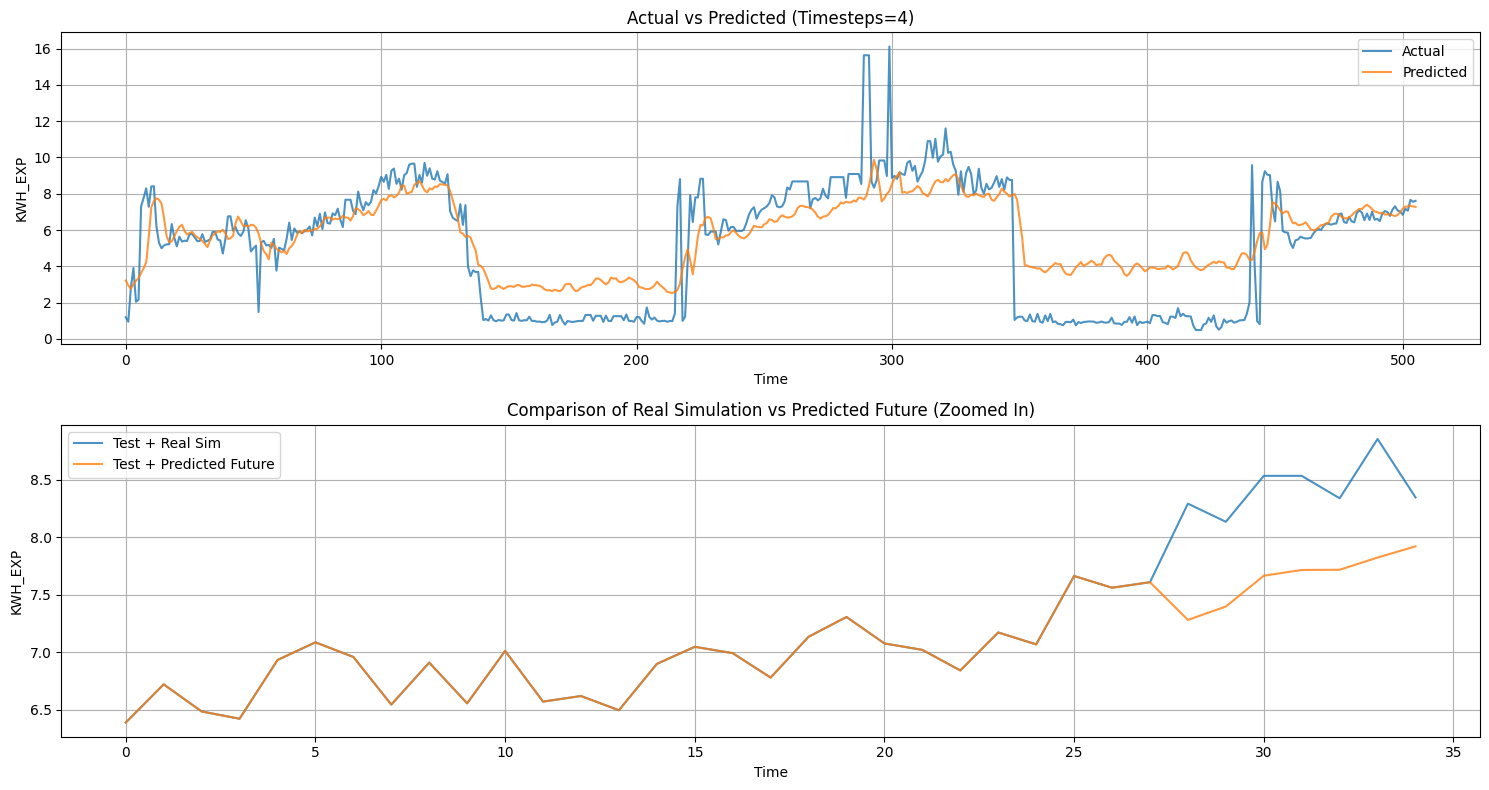


Metrics for timesteps=4:
MSE: 4.1452
R²: 0.6346
MAPE: 1.0194
MAE: 1.5582
Training time for timesteps = 4: 6.65 seconds

Training model with selected features and timesteps = 5
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


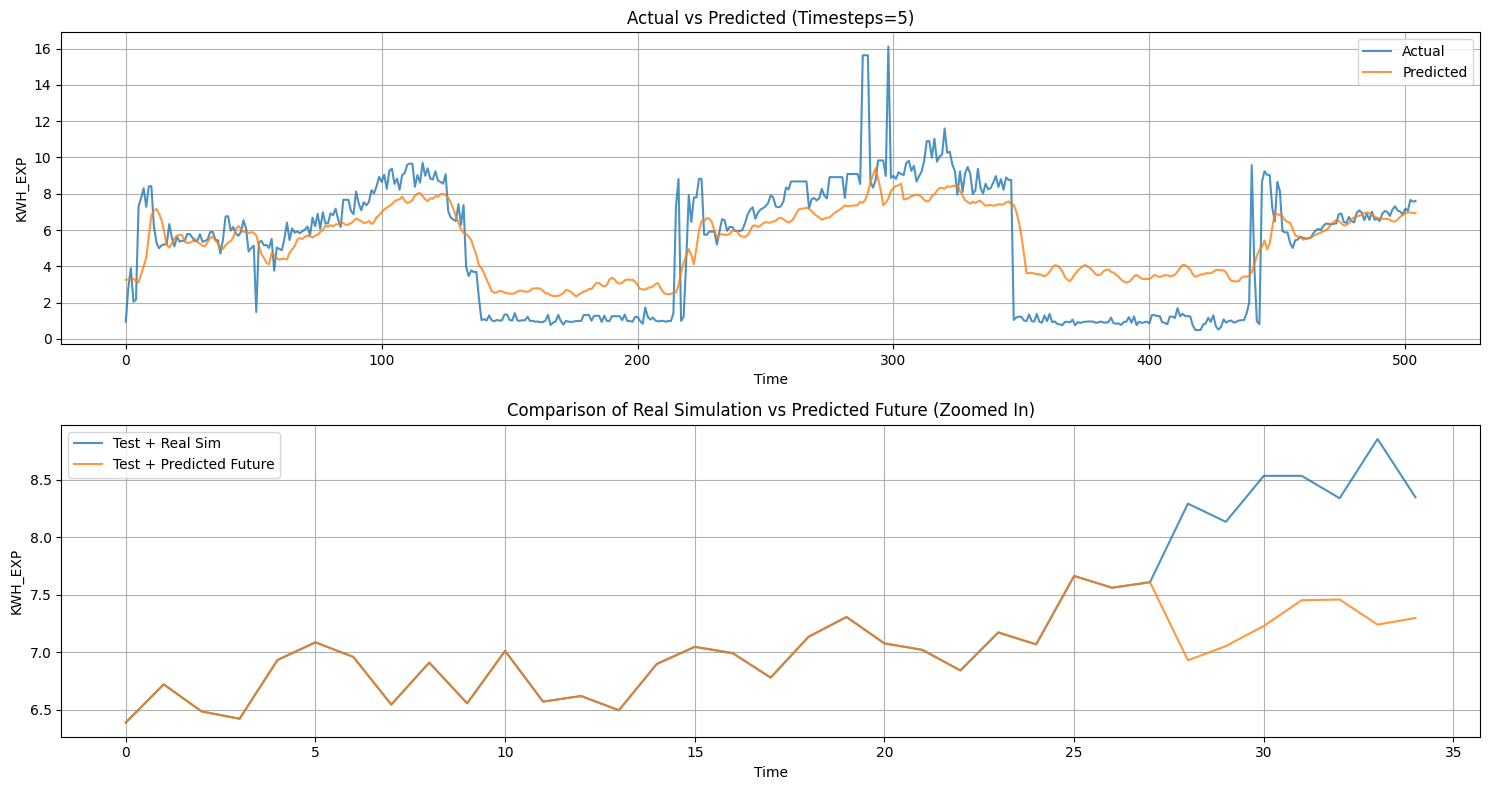


Metrics for timesteps=5:
MSE: 3.8394
R²: 0.6613
MAPE: 0.9112
MAE: 1.5418
Training time for timesteps = 5: 5.25 seconds

Training model with selected features and timesteps = 6
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


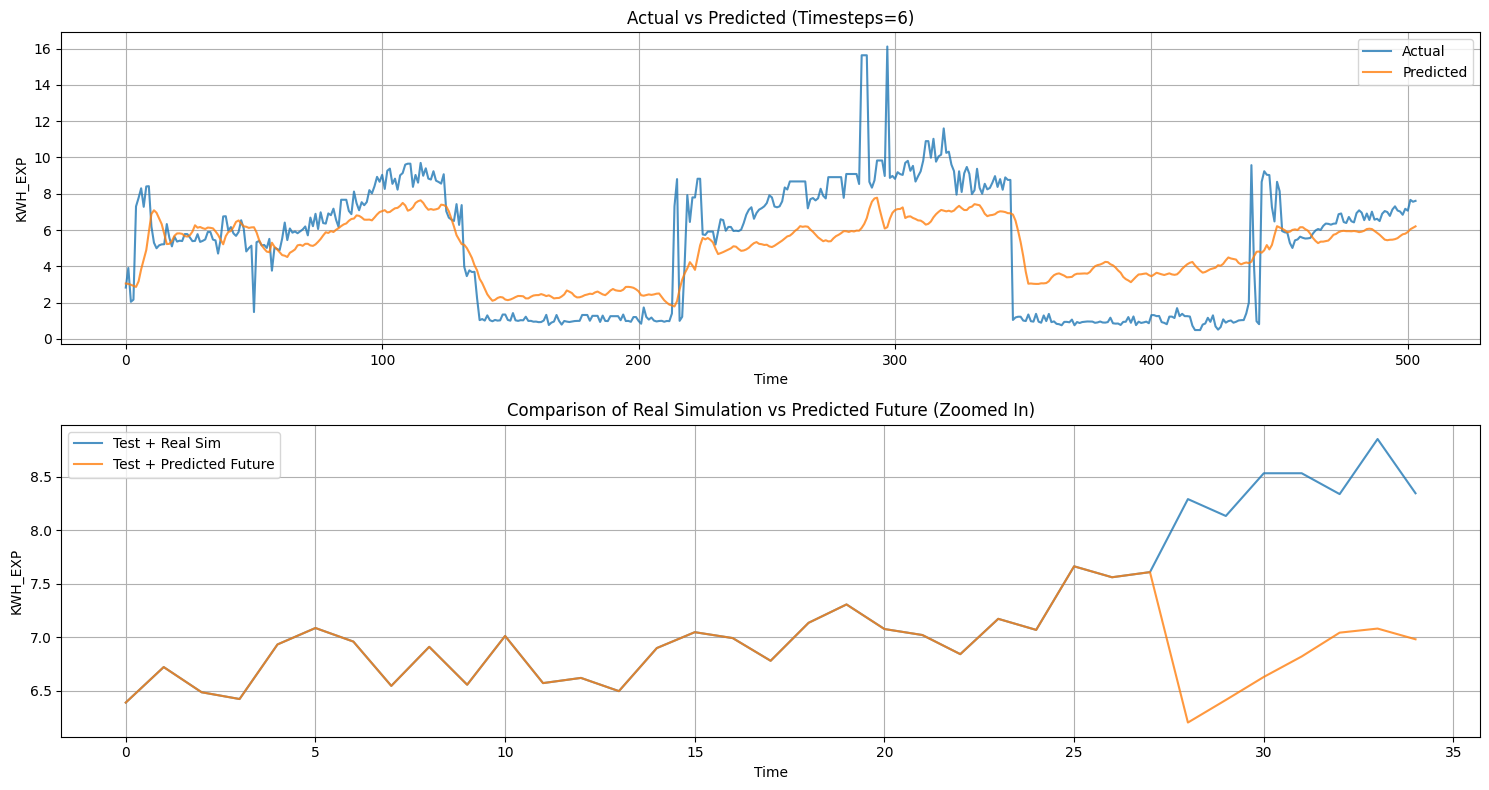


Metrics for timesteps=6:
MSE: 5.1009
R²: 0.5495
MAPE: 0.9236
MAE: 1.8458
Training time for timesteps = 6: 6.35 seconds

Training model with selected features and timesteps = 7
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


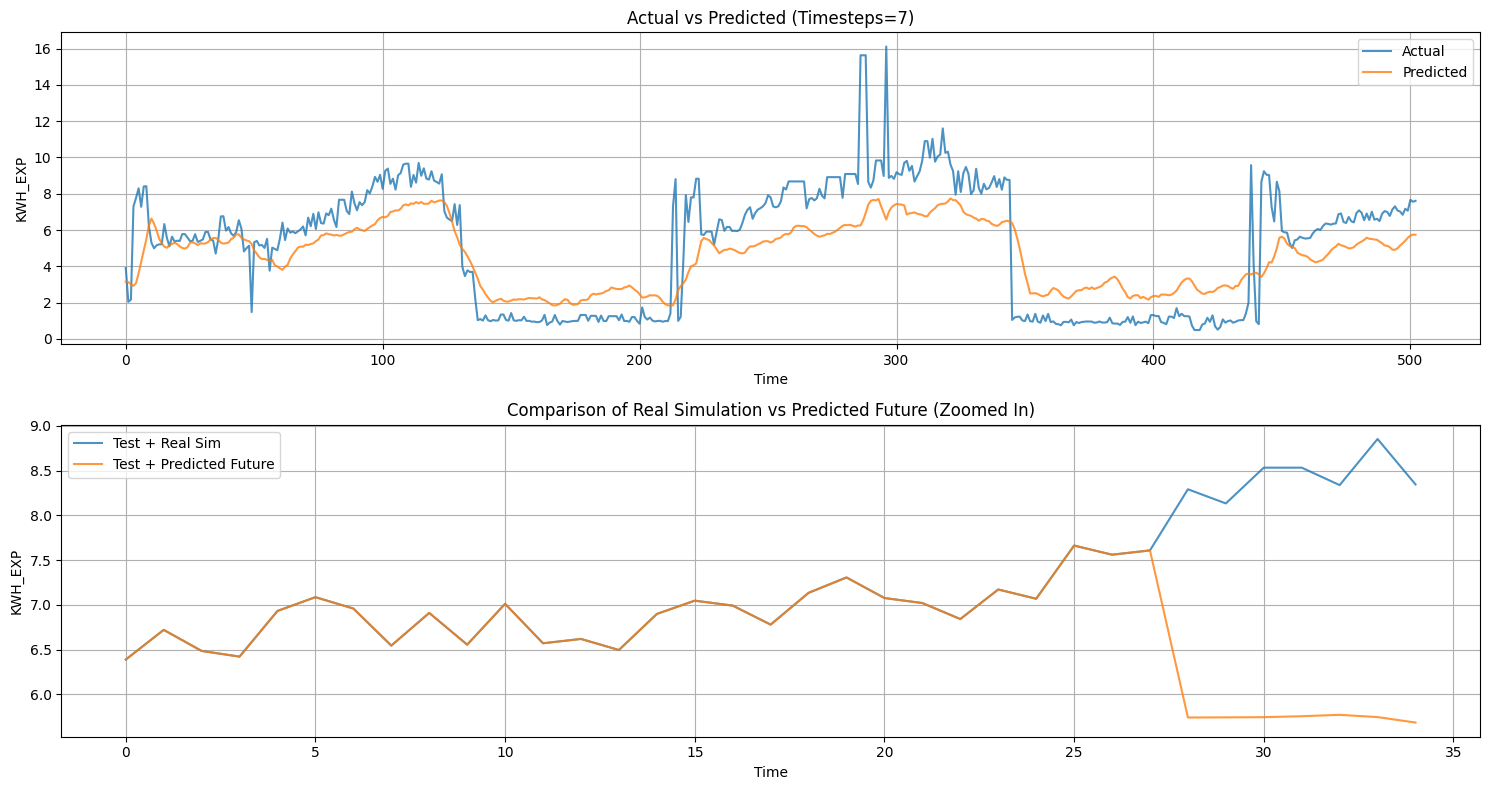


Metrics for timesteps=7:
MSE: 4.3901
R²: 0.6127
MAPE: 0.7192
MAE: 1.7271
Training time for timesteps = 7: 5.29 seconds
Total training execution time: 47.65 seconds


In [47]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")